# Analyzing F1 Data Using Neo4j

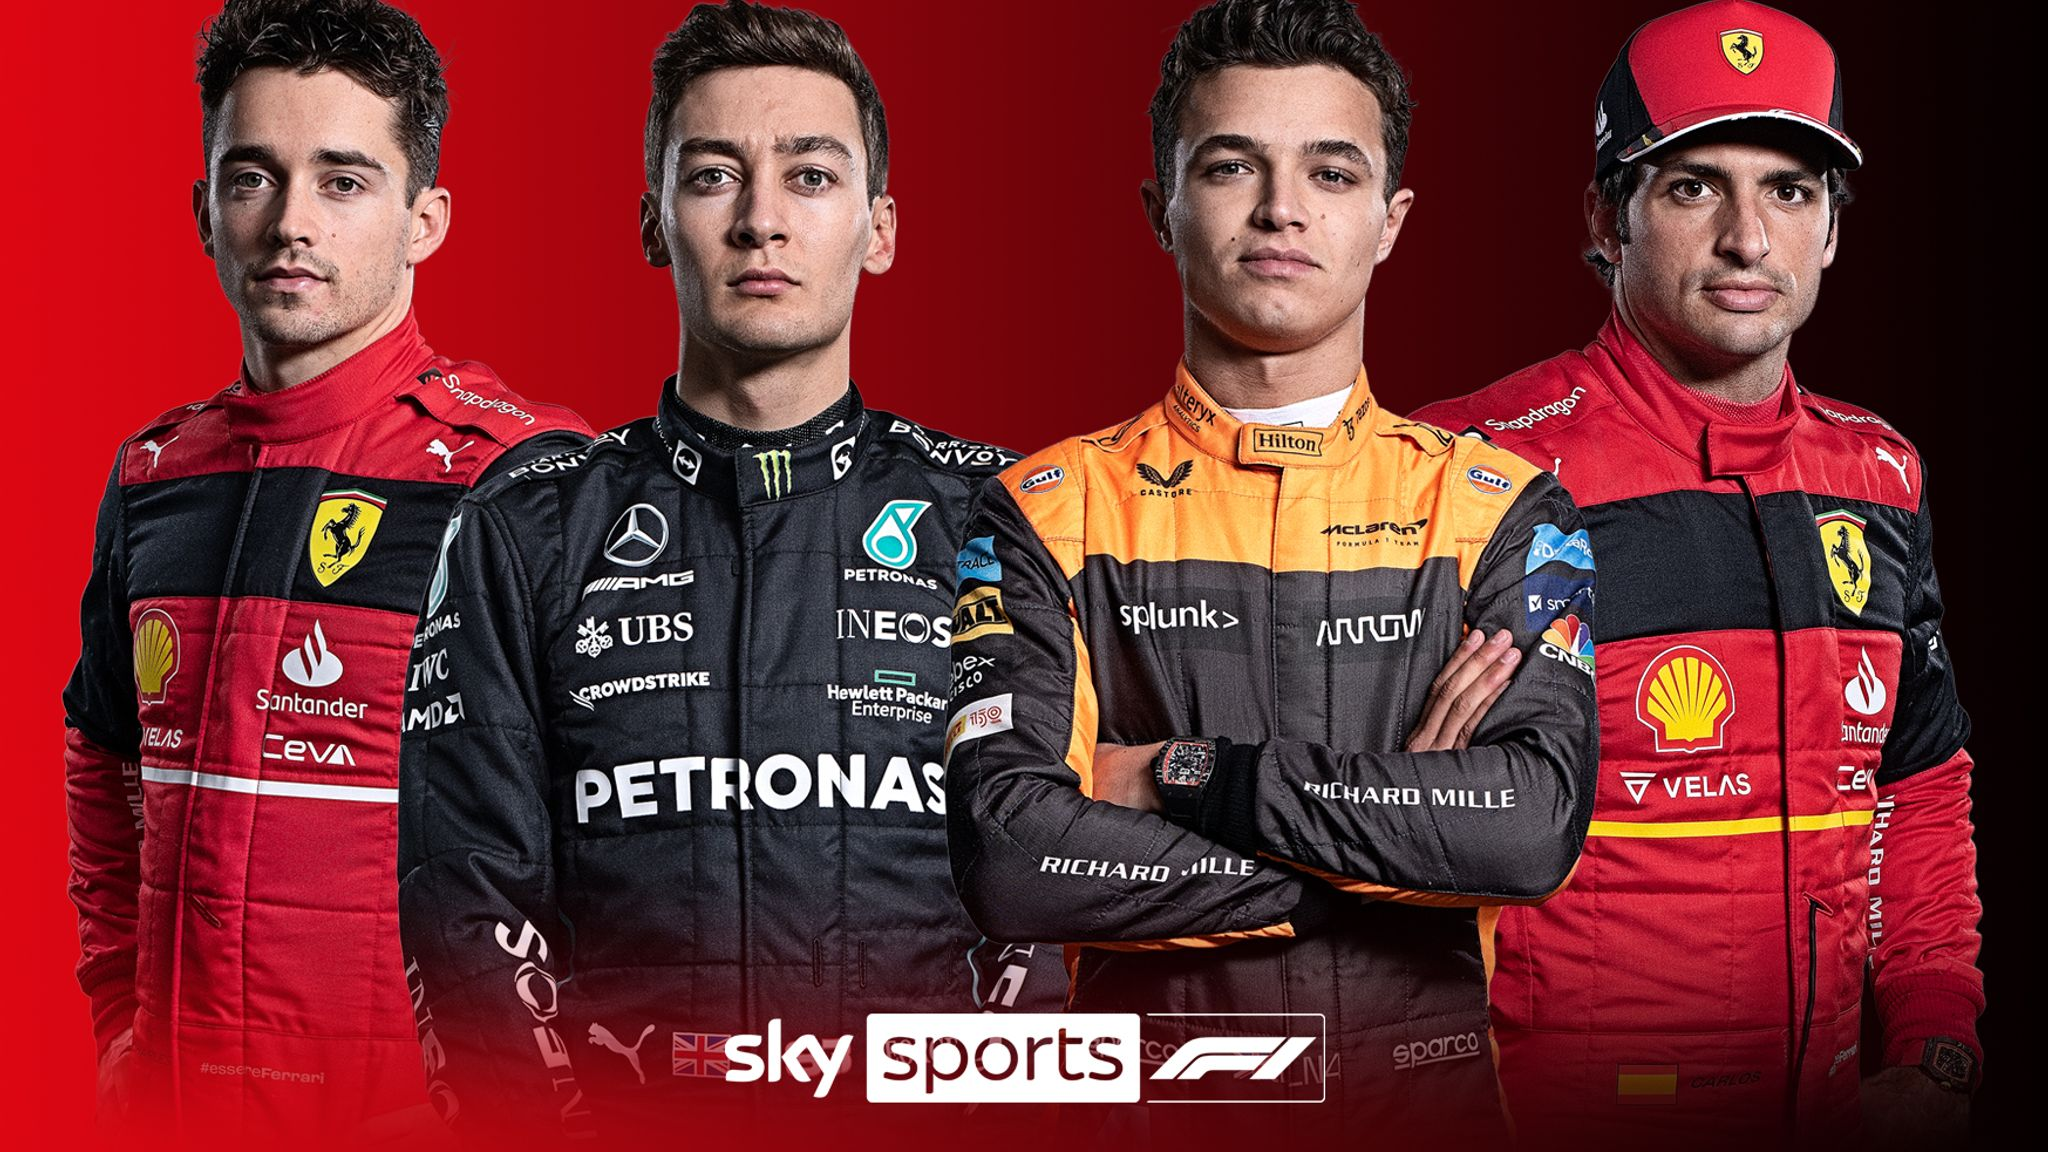

Install neo4j and import the essential libraries.

In [177]:
!pip install neo4j

In [205]:
import neo4j
from neo4j import GraphDatabase
import pandas
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Credentials for connectiong to the database in aura neo4j.

In [179]:
URI = "neo4j+s://e4b06f6d.databases.neo4j.io"
AUTH = ("neo4j", "SQjPaQXG9mpqi6ulxIXeTHF-QyJy1RK-ePRUFuLnfSM")

## Query1: Driver Championship Final Rank by Year

With this query, we can retrieve the final driver championship rankings for any desired year. The year can be changed dynamically by modifying the `year` variable below.



In [106]:
year = 2007 # change this value [1950 to 2024]

In [133]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE s.year = $year
    RETURN DISTINCT d.forename AS driverName, d.surname AS driverSurname, MAX(ds.points) AS points
    ORDER BY points DESC
    """,
    year=year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [134]:
df

,driverName,driverSurname,points
0,Kimi,Räikkönen,110
1,Lewis,Hamilton,109
2,Fernando,Alonso,109
3,Felipe,Massa,94
4,Nick,Heidfeld,61
5,Robert,Kubica,39
6,Heikki,Kovalainen,30
7,Giancarlo,Fisichella,21
8,Nico,Rosberg,20
9,David,Coulthard,14


We can dynamically visualize the final driver standings in a histogram.

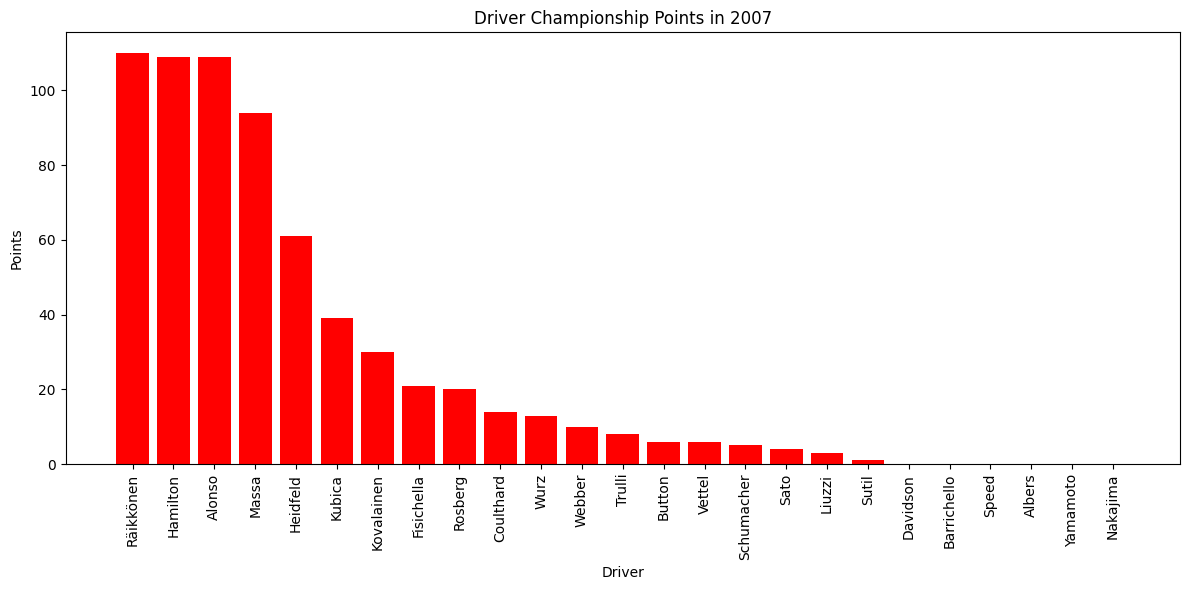

In [135]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["points"], color="red")
plt.xticks(rotation=90)
plt.title(f"Driver Championship Points in {year}")
plt.xlabel("Driver")
plt.ylabel("Points")
plt.tight_layout()
plt.show()

## Query2: Constructor Championship Final Rank by Year

With this query, we can retrieve the final constructor championship rankings for any desired year. The year can be changed dynamically by modifying the `year` variable below.

In [224]:
year = 2007 # change this value [1950 to 2024]

In [225]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WHERE s.year = 2023
    RETURN DISTINCT c.name AS constructor, MAX(cs.points) AS points
    ORDER BY points DESC
    """,
    year=year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [226]:
df

,constructor,points
0,Red Bull,860
1,Mercedes,409
2,Ferrari,406
3,McLaren,302
4,Aston Martin,280
5,Alpine F1 Team,120
6,Williams,28
7,AlphaTauri,25
8,Alfa Romeo,16
9,Haas F1 Team,12


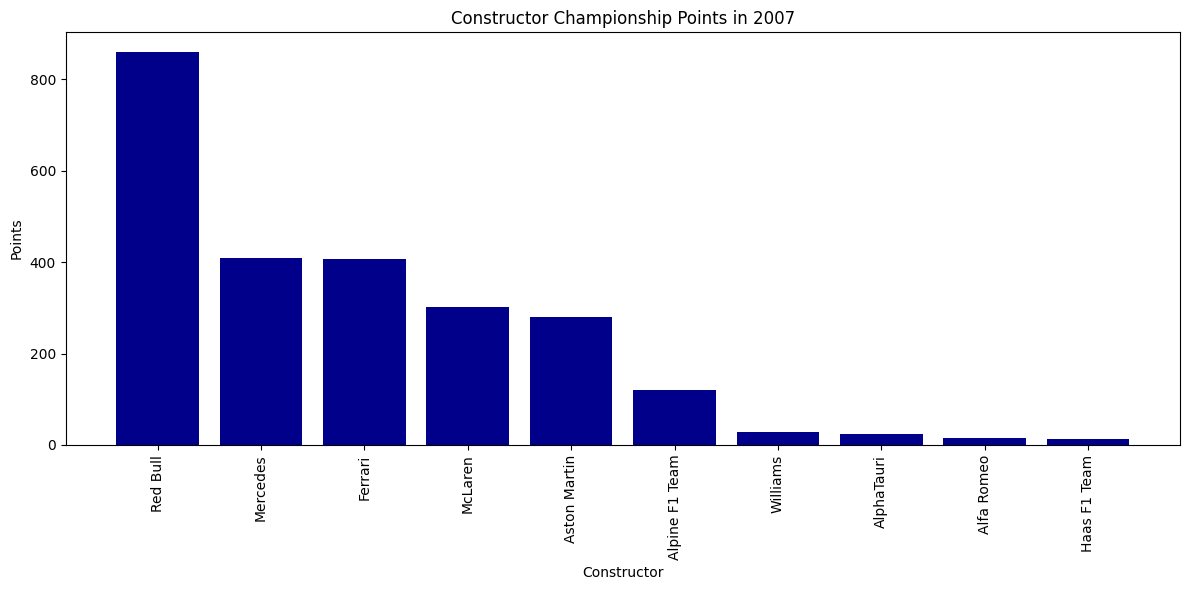

In [227]:
plt.figure(figsize=(12, 6))
plt.bar(df["constructor"], df["points"], color="darkblue")
plt.xticks(rotation=90)
plt.title(f"Constructor Championship Points in {year}")
plt.xlabel("Constructor")
plt.ylabel("Points")
plt.tight_layout()
plt.show()

## Query3: Driver Championship for Each Season

In [145]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    RETURN s.year AS Season,
           champPerYear.driverForename AS driverName,
           champPerYear.driverSurname AS driverSurname,
           champPerYear.points AS points
    ORDER BY Season DESC
    LIMIT $limit // eliminate this row to get all drivers champion for every season
    """,
    limit=15, # change this value to see more seasons
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [146]:
df

,Season,driverName,driverSurname,points
0,2024,Max,Verstappen,255
1,2023,Max,Verstappen,575
2,2022,Max,Verstappen,454
3,2021,Max,Verstappen,395
4,2020,Lewis,Hamilton,347
5,2019,Lewis,Hamilton,413
6,2018,Lewis,Hamilton,408
7,2017,Lewis,Hamilton,363
8,2016,Nico,Rosberg,385
9,2015,Lewis,Hamilton,381


## Query4: Constructor Championship for Each Season

In [147]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WITH s, c.name AS constructorName, MAX(cs.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({constructor: constructorName, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    RETURN s.year AS Season,
           champPerYear.constructor AS constructor,
           champPerYear.points AS points
    ORDER BY Season DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=15, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [148]:
df

,Season,constructorChamp,points
0,2024,Red Bull,373
1,2023,Red Bull,860
2,2022,Red Bull,759
3,2021,Mercedes,613
4,2020,Mercedes,573
5,2019,Mercedes,739
6,2018,Mercedes,655
7,2017,Mercedes,668
8,2016,Mercedes,765
9,2015,Mercedes,703


## Query5: Number of Championships per Driver

In [229]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH standsPerYear[0] AS champPerYear
    RETURN champPerYear.driverForename AS driverName,
           champPerYear.driverSurname AS driverSurname,
           COUNT(*) AS championships
    ORDER BY championships DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=20, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [230]:
df

,driverName,driverSurname,championships
0,Lewis,Hamilton,7
1,Michael,Schumacher,7
2,Juan,Fangio,5
3,Sebastian,Vettel,4
4,Alain,Prost,4
5,Max,Verstappen,4
6,Ayrton,Senna,3
7,Jack,Brabham,3
8,Niki,Lauda,3
9,Jackie,Stewart,3


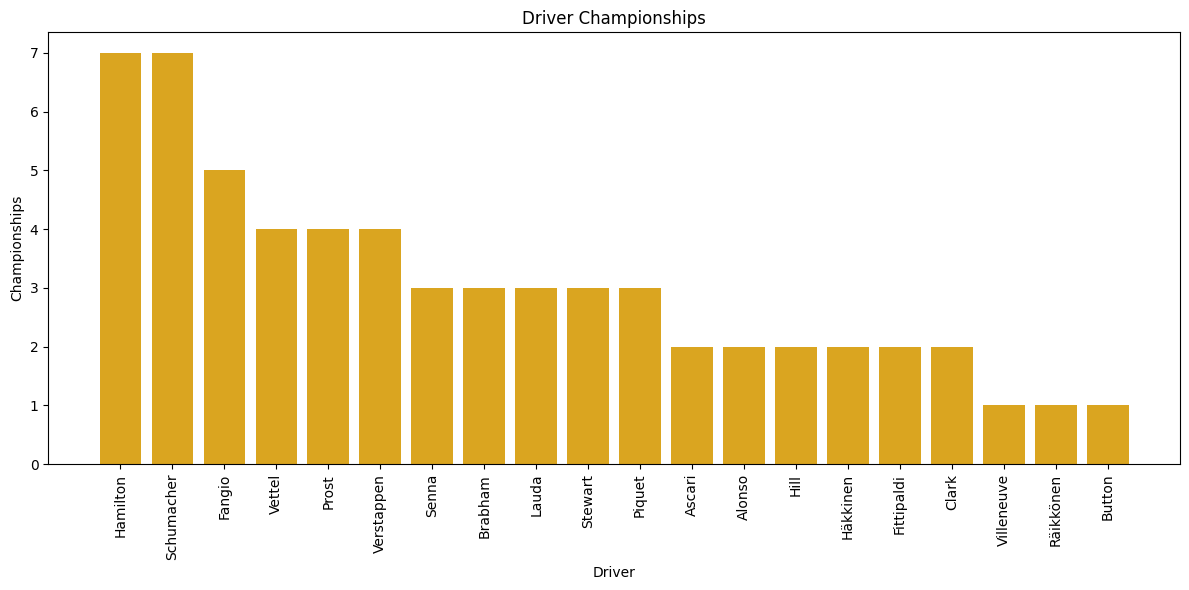

In [231]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["championships"], color="goldenrod")
plt.xticks(rotation=90)
plt.title(f"Driver Championships")
plt.xlabel("Driver")
plt.ylabel("Championships")
plt.tight_layout()
plt.show()

## Query6: Number of Championships Won by a Specific Constructor

This query provides all the seasons where the selected constructor won the championships.

In the 2007 Formula 1 season, McLaren initially scored 218 points in the Constructors' Championship. However, due to their involvement in the "Spygate" controversy, the team was disqualified from the Constructors' Championship, and their points were excluded from the final standings. This disqualification is not reflected in the database, which doesn't record the championship as being won by Ferrari, granting McLaren an additional Constructors' Championship for that year.

In [171]:
constructor = 'Ferrari' # Mercedes, McLaren, Alpine F1 Team, Williams, ...

In [172]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WITH s, c.name AS constructorName, MAX(cs.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({constructor: constructorName, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    WHERE champPerYear.constructor = $constructor
    WITH s, champPerYear AS constructorChampYear
    RETURN s.year AS Season,
           constructorChampYear.constructor AS ConstructorChamp,
           constructorChampYear.points AS Points
    ORDER BY Season DESC
    """,
    constructor=constructor,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [173]:
df

,Season,ConstructorChamp,Points
0,2008,Ferrari,172
1,2004,Ferrari,262
2,2003,Ferrari,158
3,2002,Ferrari,221
4,2001,Ferrari,179
5,2000,Ferrari,170
6,1999,Ferrari,128
7,1983,Ferrari,89
8,1982,Ferrari,74
9,1979,Ferrari,113


## Query7: Driver Champions with the Minimum Gap to the Second Place

Seasons in Formula 1 where the points allocation system changed include:  

1. **1950-1959**: Points awarded to the top five finishers (8-6-4-3-2) with 1 point for the fastest lap.  
2. **1960-1990**: Several adjustments, including points for the top six finishers (9-6-4-3-2-1).  
3. **1991-2002**: Points for the top six finishers increased for the winner (10-6-4-3-2-1).  
4. **2003-2009**: Points expanded to the top eight finishers (10-8-6-5-4-3-2-1).  
5. **2010-Present**: Major change to reward more finishers (25-18-15-12-10-8-6-4-2-1) for the top ten places.  

Considering these periods, we can determine the appropriate starting and ending time frames for analyzing the Driver Champions with the Minimum Gap to the Second Place.

In [193]:
starting_year = 2010 # 2003, 1991, 1960, 1950
ending_year = 2024 # 2009, 2002, 1990, 1959

In [194]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE r.year >= $starting_year AND r.year <= $ending_year
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, collect({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champion, standsPerYear[1] AS runnerUp
    RETURN s.year AS season,
          champion.driverForename + " " + champion.driverSurname AS champion,
          runnerUp.driverForename + " " + runnerUp.driverSurname AS runnerUp,
          champion.points - runnerUp.points AS pointsGap
    ORDER BY pointsGap ASC
    """,
    starting_year=starting_year,
    ending_year=ending_year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [195]:
df

,season,champion,runnerUp,pointsGap
0,2012,Sebastian Vettel,Fernando Alonso,3
1,2010,Sebastian Vettel,Fernando Alonso,4
2,2016,Nico Rosberg,Lewis Hamilton,5
3,2021,Max Verstappen,Lewis Hamilton,8
4,2017,Lewis Hamilton,Sebastian Vettel,46
5,2015,Lewis Hamilton,Nico Rosberg,59
6,2014,Lewis Hamilton,Nico Rosberg,67
7,2024,Max Verstappen,Lando Norris,84
8,2019,Lewis Hamilton,Valtteri Bottas,87
9,2018,Lewis Hamilton,Sebastian Vettel,88


## Query8: Most Wins at a Single Circuit by a Single Driver

This query returns each distinct circuit's most wins by a single driver, including cases where multiple drivers share the record for the most wins at a circuit.

In [239]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (c:Circuit)-[:HOLD]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE ds.position = 1
    WITH c.name AS circuit, d.surname AS driver, COUNT(d) AS wins
    ORDER BY circuit, wins DESC
    WITH circuit, MAX(wins) AS maxWins, collect({driver: driver, wins: wins}) AS driverWins
    UNWIND driverWins AS dw
    WITH circuit, maxWins, dw
    WHERE dw.wins = maxWins
    RETURN circuit, dw.driver AS driver, dw.wins AS wins
    ORDER BY wins DESC
    """,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [237]:
df

,circuit,driver,wins
0,Circuit de Spa-Francorchamps,Hamilton,9
1,Autodromo Nazionale di Monza,Hamilton,8
2,Circuit Gilles Villeneuve,Schumacher,8
3,Circuit de Monaco,Schumacher,8
4,Circuit de Nevers Magny-Cours,Schumacher,8
...,...,...,...
98,Monsanto Park Circuit,Brabham,1
99,Pescara Circuit,Fangio,1
100,Riverside International Raceway,Brabham,1
101,Sebring International Raceway,Brabham,1


We can visualize the number of most wins at a single circuit for each driver based on the records above.

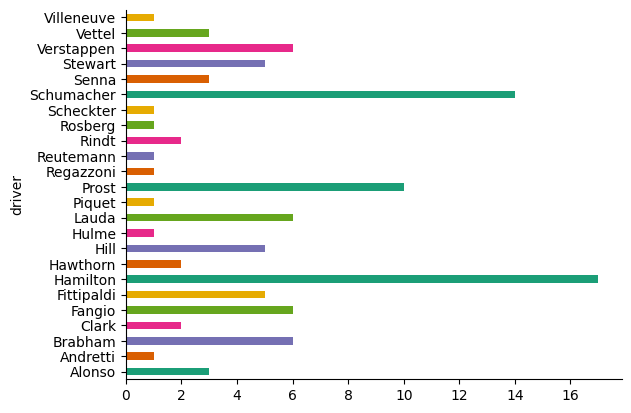

In [238]:
df.groupby('driver').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Query9: Most Starts in Pole Position Without Winning

In [246]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(r:Result)
    WHERE r.startingPosition = 1 AND r.positionOrder <> 1
    RETURN  d.forename AS driverName,
            d.surname AS driverSurname,
            COUNT(r) AS Value
    ORDER BY Value DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=20, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [247]:
df

,driverName,driverSurname,Value
0,Lewis,Hamilton,43
1,Ayrton,Senna,36
2,Michael,Schumacher,28
3,Sebastian,Vettel,26
4,Nelson,Piquet,19
5,Charles,Leclerc,19
6,Jim,Clark,19
7,Juan,Fangio,16
8,René,Arnoux,16
9,Mika,Häkkinen,16


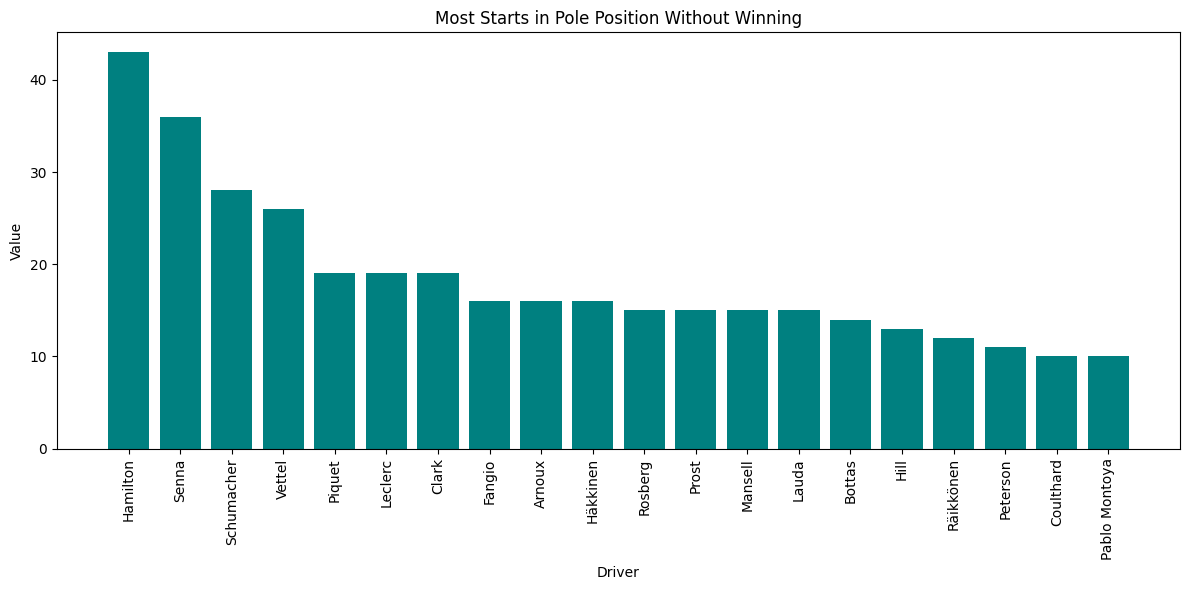

In [248]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["Value"], color="teal")
plt.xticks(rotation=90)
plt.title("Most Starts in Pole Position Without Winning")
plt.xlabel("Driver")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

## Query10: Circuit with the Highest Win Rate Starting from Pole Position

In [249]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (c:Circuit)-[:HOLD]->(r:Race)<-[:TAKE_PLACE]-(res:Result)
    WHERE res.startingPosition = 1
    WITH c,
        COUNT(res) AS totalRaces,
        SUM(CASE WHEN res.startingPosition = 1 AND res.position = 1 THEN 1 ELSE 0 END) AS winsFromPole
    WHERE totalRaces >= 15
    RETURN c.name AS Circuit,
          winsFromPole * 1.0 / totalRaces AS WinPercentage
    ORDER BY WinPercentage DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=20, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [252]:
df

,Circuit,WinPercentage
0,Circuit de Barcelona-Catalunya,0.705882
1,Yas Marina Circuit,0.666667
2,Circuit Paul Ricard,0.611111
3,Shanghai International Circuit,0.588235
4,Suzuka Circuit,0.529412
5,Circuit Gilles Villeneuve,0.488372
6,Hockenheimring,0.486486
7,Bahrain International Circuit,0.476190
8,Sepang International Circuit,0.473684
9,Circuit Park Zandvoort,0.454545


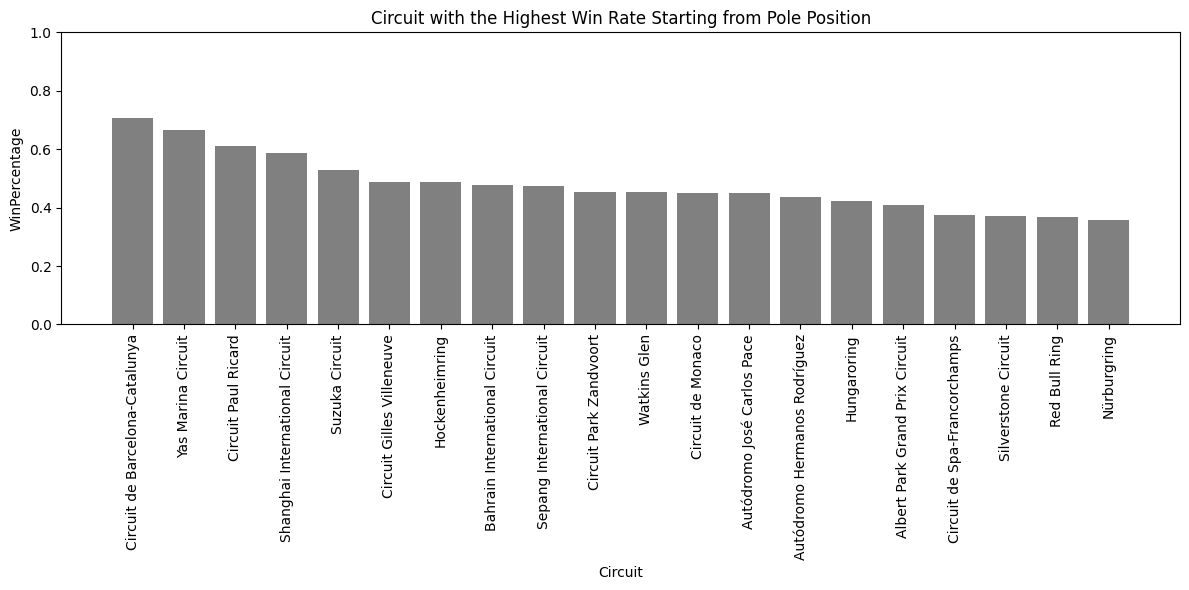

In [256]:
plt.figure(figsize=(12, 6))
plt.bar(df["Circuit"], df["WinPercentage"], color="grey")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.title("Circuit with the Highest Win Rate Starting from Pole Position")
plt.xlabel("Circuit")
plt.ylabel("WinPercentage")
plt.tight_layout()
plt.show()